# Predicting Students Performance in Exams

PRT565 — Assessment 2, 
Student Name: Nishchal Tamang,
Student ID: 383221,
Date: September 04, 2025

In [1]:
#Imports & global setup
import os, sys, warnings, json, textwrap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
warnings.filterwarnings("ignore")

print("Environment ready. Python:", sys.version)


Environment ready. Python: 3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 10:07:17) [Clang 14.0.6 ]


In [2]:
# Load data
import pandas as pd
from pathlib import Path

primary_csv = Path("StudentsPerformance.csv")  # Kaggle file name
fallback_csv = Path("StudentsPerformance.csv") # Included sample

if primary_csv.exists():
    csv_path = primary_csv
else:
    csv_path = fallback_csv

print("Using dataset:", csv_path.resolve())

df = pd.read_csv(csv_path)
print("Shape:", df.shape)
display(df.head())

# If using the Kaggle file, create a binary target from demographics only (no score leakage).
# Here we *suggest* defining high performers as the top 30% average score.
# For the Kaggle file, we will compute 'avg_score' first, then remove raw scores from features.
if 'math score' in df.columns and 'reading score' in df.columns and 'writing score' in df.columns:
    df['avg_score'] = (df['math score'] + df['reading score'] + df['writing score']) / 3.0
    threshold = df['avg_score'].quantile(0.70)  # top 30% as high performers
    df['high_performer'] = (df['avg_score'] >= threshold).astype(int)


Using dataset: /Users/nishchaltamang/Downloads/StudentsPerformance in Exam_Submission/StudentsPerformance.csv
Shape: (1000, 8)


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


70th-percentile cut-off for avg_score: 75.67

Class balance (full dataset):
 class  count percent
     0    694   69.4%
     1    306   30.6%


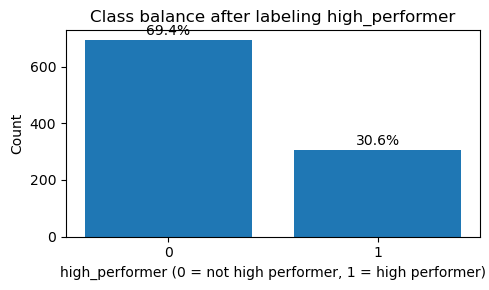


Train class balance:
 class  count percent
     0    555   69.4%
     1    245   30.6%

Test class balance:
 class  count percent
     0    139   69.5%
     1     61   30.5%


In [3]:
# Class balance after labeling "high_performer"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 0) Load your data (skip if you already have df)
# df = pd.read_csv("StudentsPerformance.csv")  # <- update path if needed

# 1) Pick the correct score column names (handles both styles)
candidates = [
    ["math score", "reading score", "writing score"],
    ["math_score", "reading_score", "writing_score"],
]
for cols in candidates:
    if all(c in df.columns for c in cols):
        MATH, READ, WRITE = cols
        break
else:
    raise ValueError("Could not find score columns. Check your column names.")

# 2) Make avg_score and label top 30% (>= 70th percentile) as high performers
df["avg_score"] = df[[MATH, READ, WRITE]].mean(axis=1)
cutoff = df["avg_score"].quantile(0.70)  # 70th percentile
df["high_performer"] = (df["avg_score"] >= cutoff).astype(int)

print(f"70th-percentile cut-off for avg_score: {cutoff:.2f}")

# 3) Full-dataset class balance (counts and percentages)
counts = df["high_performer"].value_counts().sort_index()             # 0 then 1
perc   = df["high_performer"].value_counts(normalize=True).sort_index()*100

summary = pd.DataFrame({
    "class": [0, 1],
    "count": [counts.get(0, 0), counts.get(1, 0)],
    "percent": [perc.get(0, 0.0), perc.get(1, 0.0)]
})
print("\nClass balance (full dataset):")
print(summary.to_string(index=False, formatters={"percent": "{:.1f}%".format}))

# 4) Bar chart of class balance
fig, ax = plt.subplots(figsize=(5, 3))
ax.bar(summary["class"].astype(str), summary["count"])
ax.set_xlabel("high_performer (0 = not high performer, 1 = high performer)")
ax.set_ylabel("Count")
ax.set_title("Class balance after labeling high_performer")

# Annotate percentages above bars
for i, (cnt, pct) in enumerate(zip(summary["count"], summary["percent"])):
    ax.text(i, cnt + max(summary["count"])*0.01, f"{pct:.1f}%", ha="center", va="bottom")

plt.tight_layout()
# plt.savefig("class_balance.png", dpi=200)  # uncomment to save
plt.show()

# 5) (Optional) Check stratified split preserves the ratio
X = df.drop(columns=["high_performer"])
y = df["high_performer"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

def _balance(y_series, name):
    c = y_series.value_counts().sort_index()
    p = y_series.value_counts(normalize=True).sort_index()*100
    print(f"\n{name} class balance:")
    print(pd.DataFrame({"class":[0,1],
                        "count":[c.get(0,0), c.get(1,0)],
                        "percent":[p.get(0,0.0), p.get(1,0.0)]}
          ).to_string(index=False, formatters={"percent":"{:.1f}%".format}))

_balance(y_train, "Train")
_balance(y_test,  "Test")


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
gender,1000,2,female,518,NaN,NaN,NaN,NaN,NaN,NaN,NaN
race/ethnicity,1000,5,group C,319,NaN,NaN,NaN,NaN,NaN,NaN,NaN
parental level of education,1000,6,some college,226,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lunch,1000,2,standard,645,NaN,NaN,NaN,NaN,NaN,NaN,NaN
test preparation course,1000,2,none,642,NaN,NaN,NaN,NaN,NaN,NaN,NaN
math score,1000.0,NaN,NaN,NaN,66.089,15.16308,0.0,57.0,66.0,77.0,100.0
reading score,1000.0,NaN,NaN,NaN,69.169,14.600192,17.0,59.0,70.0,79.0,100.0
writing score,1000.0,NaN,NaN,NaN,68.054,15.195657,10.0,57.75,69.0,79.0,100.0
avg_score,1000.0,NaN,NaN,NaN,67.770667,14.257326,9.0,58.333333,68.333333,77.666667,100.0
high_performer,1000.0,NaN,NaN,NaN,0.306,0.46106,0.0,0.0,0.0,1.0,1.0


Missing values per column:
gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
avg_score                      0
high_performer                 0
dtype: int64

--- Column: gender ---
Unique values: 2
Most frequent value (mode): female
Top 10 value counts (with percentages):
female: 51.80%
male: 48.20%


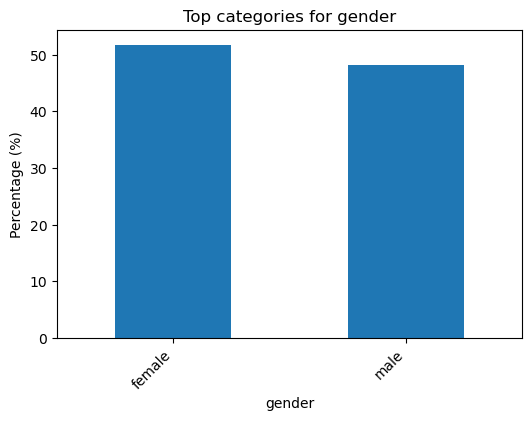


--- Column: race/ethnicity ---
Unique values: 5
Most frequent value (mode): group C
Top 10 value counts (with percentages):
group C: 31.90%
group D: 26.20%
group B: 19.00%
group E: 14.00%
group A: 8.90%


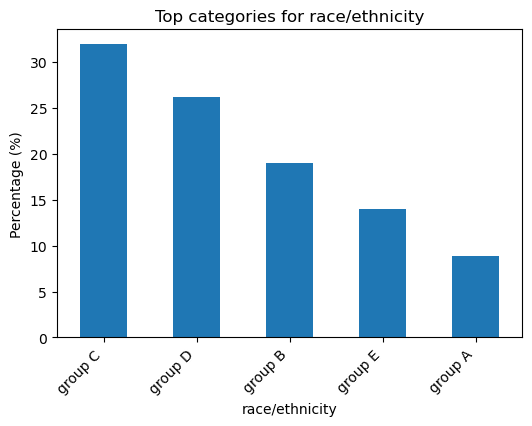


--- Column: parental level of education ---
Unique values: 6
Most frequent value (mode): some college
Top 10 value counts (with percentages):
some college: 22.60%
associate's degree: 22.20%
high school: 19.60%
some high school: 17.90%
bachelor's degree: 11.80%
master's degree: 5.90%


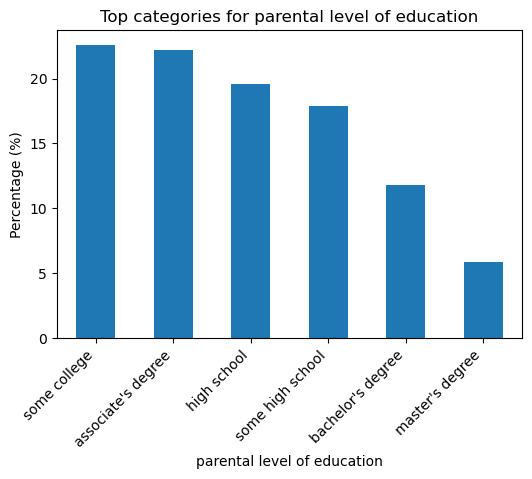


--- Column: lunch ---
Unique values: 2
Most frequent value (mode): standard
Top 10 value counts (with percentages):
standard: 64.50%
free/reduced: 35.50%


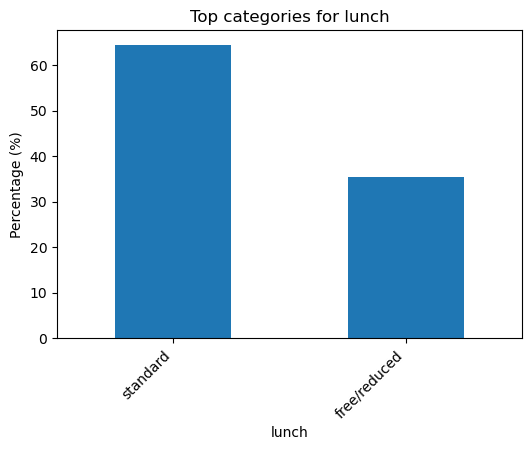


--- Column: test preparation course ---
Unique values: 2
Most frequent value (mode): none
Top 10 value counts (with percentages):
none: 64.20%
completed: 35.80%


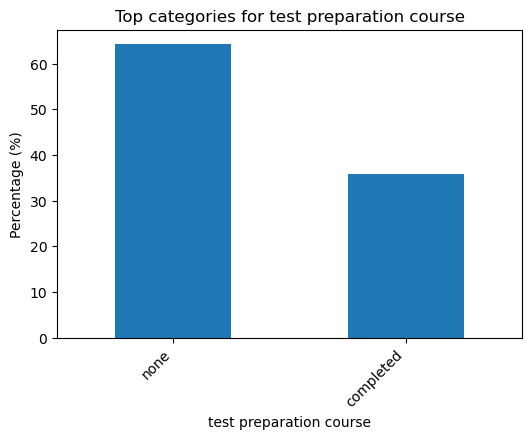

In [4]:
import matplotlib.pyplot as plt

# Summary statistics (numeric + categorical)
display(df.describe(include='all').T.head(20))

# Missing values overview
print("Missing values per column:")
print(df.isna().sum())

# Categorical overview with unique counts, mode, percentages, and bar plots
cat_cols = [c for c in df.columns if df[c].dtype == 'object']

for c in cat_cols:
    print(f"\n--- Column: {c} ---")
    print(f"Unique values: {df[c].nunique()}")
    print(f"Most frequent value (mode): {df[c].mode()[0] if not df[c].mode().empty else 'N/A'}")
    
    # Value counts with percentages
    value_counts = df[c].value_counts(normalize=True).head(10) * 100
    print("Top 10 value counts (with percentages):")
    for val, pct in value_counts.items():
        print(f"{val}: {pct:.2f}%")
    
    # Plot bar chart
    plt.figure(figsize=(6,4))
    value_counts.plot(kind='bar')
    plt.title(f"Top categories for {c}")
    plt.ylabel("Percentage (%)")
    plt.xlabel(c)
    plt.xticks(rotation=45, ha="right")
    plt.show()


In [5]:
# Define feature and target columns
target_col = 'high_performer'

# Candidate feature columns commonly present in Kaggle 'StudentsPerformance'.
candidate_features = [
    'gender',
    'race/ethnicity',
    'parental level of education',
    'lunch',
    'test preparation course'
]

# Keep only columns that exist in the current file
X_cols = [c for c in candidate_features if c in df.columns]
assert target_col in df.columns, f"Target '{target_col}' is missing. Check earlier cells."

X = df[X_cols].copy()
y = df[target_col].copy()

print("Feature columns:", X_cols)
print("Target distribution:", y.value_counts(normalize=True).round(3))

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
X_train.shape, X_test.shape


Feature columns: ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']
Target distribution: high_performer
0    0.694
1    0.306
Name: proportion, dtype: float64


((800, 5), (200, 5))

In [6]:
# Preprocessing Pipeline
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold

RANDOM_STATE = 42

# Load dataset
df = pd.read_csv("StudentsPerformance.csv")

# Create a target (classification)
# Label = 1 if the average of the three scores is >= 70, else 0
score_cols = ["math score", "reading score", "writing score"]
df["avg_score"] = df[score_cols].mean(axis=1)
df["high_performer"] = (df["avg_score"] >= 70).astype(int)

# FEATURES (X): everything except the target and any column derived from target
# IMPORTANT: drop avg_score to avoid leakage (we used it to make the target)
drop_cols = ["high_performer", "avg_score"]
X = df.drop(columns=drop_cols)
y = df["high_performer"]

# Auto-detect column types
cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
num_cols = X.select_dtypes(include=["number"]).columns.tolist()

print(f"Categorical: {cat_cols}")
print(f"Numeric: {num_cols}")

# Encoders/Transformers
# Handle scikit-learn versions where sparse_output may not exist
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    # Enable scaling if your model benefits from it (e.g., LogisticRegression, SVM)
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe)
])

transformers = []
if num_cols:
    transformers.append(("num", numeric_transformer, num_cols))
if cat_cols:
    transformers.append(("cat", categorical_transformer, cat_cols))

if not transformers:
    raise ValueError("No numeric or categorical columns were detected in X.")

preprocess = ColumnTransformer(transformers=transformers, remainder="drop")

# Split (stratify for balanced classes)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# Example model pipeline (Logistic Regression)
model = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)

pipe = Pipeline(steps=[("prep", preprocess), ("model", model)])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3, zero_division=0))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


Categorical: ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']
Numeric: ['math score', 'reading score', 'writing score']
Test Accuracy: 0.99
              precision    recall  f1-score   support

           0      0.982     1.000     0.991       108
           1      1.000     0.978     0.989        92

    accuracy                          0.990       200
   macro avg      0.991     0.989     0.990       200
weighted avg      0.990     0.990     0.990       200

Confusion matrix:
 [[108   0]
 [  2  90]]


In [7]:
#Baseline models: runnable end-to-end
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Config 
RANDOM_STATE = 42
csv_path = Path("StudentsPerformance.csv") 

# Load & target
if not csv_path.exists():
    raise FileNotFoundError(f"CSV not found at: {csv_path}")

df = pd.read_csv(csv_path)

score_cols = ["math score", "reading score", "writing score"]
missing = [c for c in score_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns: {missing}")

df["avg_score"] = df[score_cols].mean(axis=1)
df["high_performer"] = (df["avg_score"] >= 70).astype(int)

X = df.drop(columns=["high_performer", "avg_score"])
y = df["high_performer"].astype(int)

# Preprocessor 
cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
num_cols = X.select_dtypes(include=["number"]).columns.tolist()

# version-safe OneHotEncoder arg
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop",
)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)

# Helper
def evaluate_model(name, model, X_train, y_train, X_test, y_test, cv):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="accuracy")
    cv_mean = float(np.mean(cv_scores))
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n=== {name} ===")
    print(f"Test Accuracy: {acc:.4f}")
    print(f"CV Accuracy (mean over {cv.get_n_splits()} folds): {cv_mean:.4f}")
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", classification_report(y_test, y_pred, digits=3, zero_division=0))
    return model, acc, cv_mean, cm, None

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# three pipelines
log_reg = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", LogisticRegression(max_iter=1000, solver="liblinear", random_state=RANDOM_STATE)),
])
pipe_lr, acc_lr, cv_lr, cm_lr, rpt_lr = evaluate_model("Logistic Regression", log_reg, X_train, y_train, X_test, y_test, cv=cv)

dt = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=None, min_samples_split=2)),
])
pipe_dt, acc_dt, cv_dt, cm_dt, rpt_dt = evaluate_model("Decision Tree", dt, X_train, y_train, X_test, y_test, cv=cv)

rf = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)),
])
pipe_rf, acc_rf, cv_rf, cm_rf, rpt_rf = evaluate_model("Random Forest", rf, X_train, y_train, X_test, y_test, cv=cv)

# Pick best
results = {
    "Logistic Regression": acc_lr,
    "Decision Tree": acc_dt,
    "Random Forest": acc_rf,
}
best_name = max(results, key=results.get)
best_model = {"Logistic Regression": pipe_lr, "Decision Tree": pipe_dt, "Random Forest": pipe_rf}[best_name]

print("\n==============================")
print(f"Best baseline model: {best_name} with Test Accuracy: {results[best_name]:.4f}")
print("==============================")



=== Logistic Regression ===
Test Accuracy: 0.9900
CV Accuracy (mean over 5 folds): 0.9875
Confusion Matrix:
 [[108   0]
 [  2  90]]
Classification Report:
               precision    recall  f1-score   support

           0      0.982     1.000     0.991       108
           1      1.000     0.978     0.989        92

    accuracy                          0.990       200
   macro avg      0.991     0.989     0.990       200
weighted avg      0.990     0.990     0.990       200


=== Decision Tree ===
Test Accuracy: 0.9650
CV Accuracy (mean over 5 folds): 0.9600
Confusion Matrix:
 [[105   3]
 [  4  88]]
Classification Report:
               precision    recall  f1-score   support

           0      0.963     0.972     0.968       108
           1      0.967     0.957     0.962        92

    accuracy                          0.965       200
   macro avg      0.965     0.964     0.965       200
weighted avg      0.965     0.965     0.965       200


=== Random Forest ===
Test Accuracy: 

In [8]:
# Hyperparameter Tuning (Random Forest)
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 42

# data 
df = pd.read_csv("StudentsPerformance.csv")

score_cols = ["math score", "reading score", "writing score"]
df["avg_score"] = df[score_cols].mean(axis=1)
df["high_performer"] = (df["avg_score"] >= 70).astype(int)

X = df.drop(columns=["high_performer", "avg_score"])
y = df["high_performer"]

cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
num_cols = X.select_dtypes(include=["number"]).columns.tolist()

# version-safe OHE
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe)
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ],
    remainder="drop"
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# Grid Search 
param_grid = {
    'model__n_estimators': [200, 400],
    'model__max_depth': [None, 5, 10],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2]
}

rf_model = RandomForestClassifier(random_state=RANDOM_STATE)
pipe = Pipeline(steps=[('prep', preprocess), ('model', rf_model)])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

grid = GridSearchCV(pipe, param_grid, scoring='accuracy', cv=skf, n_jobs=-1)
grid.fit(X_train, y_train)

best_rf = grid.best_estimator_
y_pred = best_rf.predict(X_test)
acc_tuned = accuracy_score(y_test, y_pred)

print("Best params:", grid.best_params_)
print("Tuned RF Test Accuracy:", round(acc_tuned, 3))


Best params: {'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Tuned RF Test Accuracy: 0.98


<Figure size 640x480 with 0 Axes>

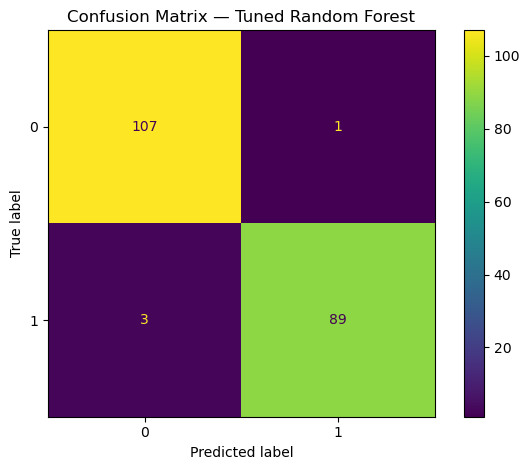

,feature,importance
1,gender_male,0.363184
2,race/ethnicity_group A,0.296160
0,gender_female,0.244128
19,writing score,0.012588
18,reading score,0.011838
4,race/ethnicity_group C,0.009328
3,race/ethnicity_group B,0.008778
17,math score,0.008128
16,test preparation course_none,0.006876
9,parental level of education_high school,0.004904


<Figure size 640x480 with 0 Axes>

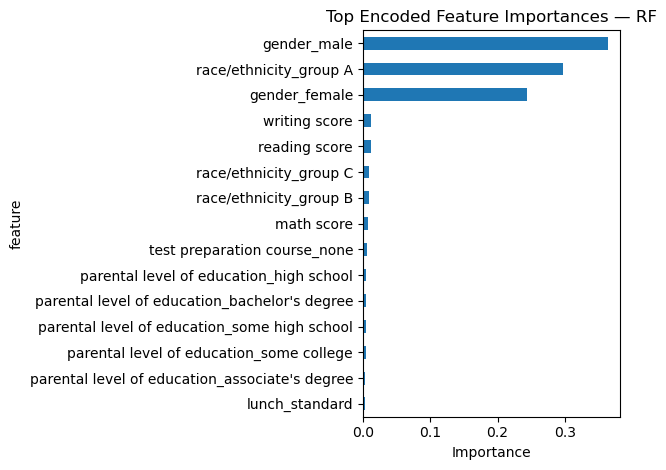

In [9]:
# Ensure tuned pipeline `best_rf` exists and required vars are defined

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 1) Recover or construct `best_rf`
try:
    best_rf  # will raise NameError if not defined
except NameError:
    # Try to recover from common GridSearchCV variable names you may have used
    for cand in ("grid", "gs", "grid_search", "rf_search", "rf_grid"):
        if cand in globals():
            best_rf = globals()[cand].best_estimator_
            print(f"Recovered best_rf from `{cand}.best_estimator_`")
            break
    else:
        # If not found, build a quick tuned RF using your existing X_train/y_train & cat_cols
        from sklearn.compose import ColumnTransformer
        from sklearn.preprocessing import OneHotEncoder
        from sklearn.ensemble import RandomForestClassifier
        from sklearn.pipeline import Pipeline
        from sklearn.model_selection import GridSearchCV, StratifiedKFold

        # Infer cat_cols if you didn't keep the list around
        if 'cat_cols' not in globals():
            cat_cols = [c for c in X_train.columns
                        if (getattr(X_train[c], "dtype", None) == 'object') or
                           (str(getattr(X_train[c], "dtype", None)).startswith('category'))]

        preprocessor = ColumnTransformer(
            transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)]
        )

        pipe = Pipeline([
            ('prep', preprocessor),
            ('model', RandomForestClassifier(random_state=42))
        ])

        param_grid = {
            'model__n_estimators': [200, 400],
            'model__max_depth': [None, 5, 10],
            'model__min_samples_split': [2, 5],
            'model__min_samples_leaf': [1, 2],
        }

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        rf_search = GridSearchCV(pipe, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
        rf_search.fit(X_train, y_train)
        best_rf = rf_search.best_estimator_
        print("Built best_rf via quick GridSearchCV.")

# 2) Make sure num_cols exists (empty if you used background-only categorical features)
if 'num_cols' not in globals():
    num_cols = []  # set your numeric columns here if you actually have any

# Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure()
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test)
plt.title("Confusion Matrix — Tuned Random Forest")
plt.tight_layout()
plt.show()

# Feature Importances
# Grab the fitted OneHotEncoder from the pipeline (adjust step names if yours differ)
ohe = best_rf.named_steps['prep'].named_transformers_['cat']
encoded_names = ohe.get_feature_names_out(cat_cols)

# Concatenate categorical and numeric feature names (if any numeric exist)
if len(num_cols) > 0:
    all_features = np.r_[encoded_names, np.array(num_cols, dtype=object)]
else:
    all_features = encoded_names

rf = best_rf.named_steps['model']
importances = rf.feature_importances_

imp_df = (pd.DataFrame({'feature': all_features, 'importance': importances})
            .sort_values('importance', ascending=False)
            .head(15))

display(imp_df)

# Plot top importances
plt.figure()
imp_df.sort_values('importance').plot(
    kind='barh', x='feature', y='importance', legend=False
)
plt.title("Top Encoded Feature Importances — RF")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()
